### Formulating Wardrop Equilibria Under Heterogenous Information Provision


A dynamic path flow pattern $ f^{i,t}_{pw}$ in DUE-HIP if for every class $(i, w)$ at every discrete time $t$, the following conditions hold:

$$ c_{p}^{i,t} = \sum_{a \in p} t_a(x_a^{t})
\left\{
\begin{array}{ll}
     = u_{w}^{i,t}, & \text{if } f^{i,t}_{pw} > 0, \\
     \geq u_{w}^{i,t}, & \text{if } f^{i,t}_{pw} = 0,
\end{array} 
\right. 
$$

where $u_{w}^{i,t}$ is the minimum path travel time among paths in $P_{w}^{i}$ at time $t $.


A flow pattern $f^{*,i,t}$ is a DUE-HIP if and only if it solves the following dynamic variational inequality:

$$
\sum_{w \in [W]} \sum_{i \in [K]} \sum_{p \in P_{w}^{i}} c_{p}^{i,t} \left( f^{*,i,t} \right) \left( f^{i,t}_{pw} - f^{i, s,t}_{pw} \right) \geq 0, \quad \forall f^{i,t} \in \Omega^{i,t}
$$

In [90]:
import numpy as np
import pandas as pd
from scipy import sparse
import scipy
import matplotlib.pyplot as plt
import networkx as nx
import uuid

In [301]:
class Network:
    def __init__(self, delta_t):
        #self.G = self.read_tntp_net("data/SiouxFalls/SiouxFalls_net.tntp")
        #self.read_node_file("data/SiouxFalls/SiouxFalls_node.tntp", self.G)
        
        self.G = self.read_tntp_net("Nguyen-Dupuis/Nguyen-Dupuis_net.tntp") 
        
        self.delta_t = delta_t
        self.vehicles = []
        #self.demand = read_demand('data/SiouxFalls/SiouxFalls')
        self.demand = self.read_demand('Nguyen-Dupuis/Nguyen-Dupuis')
        self.demand_matrix = self.demand.todense()
        self.demand_profile = self.generate_demand_based_on_headway(headway = 0.5)  # 0.5 sec/veh headway
        self.origin_mapping = {0: 1, 1: 4}
        self.destination_mapping = {0: 2, 1: 3}
        
        # Pre-compute and initialize edge attributes
        for u, v, data in self.G.edges(data=True):
            data['density'] = []
            data['flow'] = []
            C = (data['capacity'] / 3600) * self.delta_t # Capacity flow; Convert from veh/hour to veh/timestep
            rho_c = C / data['free_flow_speed'] #Critical density
            data['C'] = C
            data['rho_c'] = rho_c
            
            #kj = rho_c * (data['free_flow_speed'] / (data['free_flow_speed'] - C / rho_c))
            #data['jam_density'] = kj 
            
            N_max = data['saturation_flow'] * data['free_flow_time'] / self.delta_t #Here kj (jam density) = Max number of vehicle calculated by saturation flow.
            data['jam_density'] = N_max
            
    def read_tntp_net(self,filename):
        G = nx.DiGraph()
        with open(filename, 'r') as file:
            reading_data = False
            for line in file:
                if line.strip() == '<END OF METADATA>':
                    reading_data = True
                    continue

                if reading_data:
                    # Skip lines with tildes or that are comments
                    if line.strip().startswith("~") or line.strip().startswith(";"):
                        continue

                    values = line.strip().split('\t')
                    try:
                        # Ensure that there are enough values to unpack and each is not empty
                        if len(values) >= 5 and all(v != '' for v in values[:5]):  
                            init_node, term_node, capacity, length, free_flow_time,b,power,speed,toll,link_type,saturation_flow = map(float, values[:11])  #Check this length with tntp file
                            free_flow_speed = length / free_flow_time  # Calculate free-flow speed

                            G.add_edge(int(init_node), int(term_node), capacity=capacity, length=length, free_flow_time=free_flow_time,free_flow_speed = free_flow_speed,
                                      b=b,power=power,speed=speed,toll=toll,link_type=link_type, saturation_flow = saturation_flow)                        

                    except ValueError as e:
                        print(f"Skipping line due to error: {e}")
                        print("Line:", line)
        return G
    
    def read_node_file(self,filename, G):
        with open(filename, 'r') as file:
            for line in file:
                values = line.strip().split('\t')
                if len(values) >= 3:
                    # Attempt to convert to float, skip if not possible
                    try:
                        node, x, y = map(float, values[:3])
                        G.nodes[int(node)]['x'] = x
                        G.nodes[int(node)]['y'] = y
                    except ValueError:
                        # Skip header or any line that cannot be converted to float
                        continue

    def read_demand(self,path):
        """
        Parameter: 
            file: a file name that encode the demand under a TNTP format (network_trips.tntp).
        Return:
            A dictionary of keys based sparse matrix encoding the demand.
        """
        file_type = "trips"
        file = path + "_" + file_type + ".tntp"
        inputfile = open(file)
        line = inputfile.readline()
        # parsing metadata
        while "<" in line:
            print(line, end="")
            line = inputfile.readline()

        # skip all the blank line
        while len(line)<2:
            line = inputfile.readline()

        # read the Origin
        assert 'Origin' in line
        data = {}
        # print(line, end="")
        origin = None
        try:
            origin = int(line.split('\t')[1])
        except:
            origin = int(line.split(' ')[1])
        data[origin] = {}
        for line in inputfile:
            # print(line, end="")
            if 'Origin ' in line:
                origin = None
                try:
                    origin = int(line.split('\t')[1])
                except:
                    origin = int(line.split(' ')[1])
                data[origin] = {}
            # else read the destination
            else:
                dest_array = line.split(";")
                for dest in dest_array[:-1]:
                    dest_tmp = dest.split(":")
                    data[origin][int(dest_tmp[0])] = float(dest_tmp[1])

        d = pd.DataFrame(data)
        del data

        demand = sparse.csr_matrix(np.array(d))
        del d
        # print(demand)
        return demand.todok()                   

    def generate_demand_based_on_headway(self, headway):
        demand_profile = {}
        vehicles_to_depart = self.demand_matrix.copy()
        timestep = 0

        while np.sum(vehicles_to_depart) > 0:
            vehicles_this_timestep = np.minimum(vehicles_to_depart, np.floor(1 / headway))
            demand_profile[timestep] = vehicles_this_timestep
            vehicles_to_depart -= vehicles_this_timestep
            timestep += 1

        return demand_profile
                                         
    def insert_new_vehicles(self, t):
        if t in self.demand_profile:
            for index_origin, row in enumerate(self.demand_profile[t]):
                origin = self.origin_mapping[index_origin]
                for index_dest, num_vehicles in enumerate(row.A1):
                    dest = self.destination_mapping[index_dest]
                    for _ in range(int(num_vehicles)):
                        vehicle_id = str(uuid.uuid4())
                        route = self.assign_initial_path(origin, dest)[1:]  # Skip the origin node
                        path = self.assign_initial_path(origin, dest)
                        current_edge = (origin, route[0]) if len(route) > 0 else None

                        self.vehicles.append({
                            'vehicle_id': vehicle_id,
                            'origin': origin,
                            'destination': dest,
                            'departure_time': t,
                            'current_edge': current_edge,
                            'position': 0.0,
                            'route': route
                        })

                        # Increment the edge density for the current edge of this vehicle
                        if current_edge:
                            edge_data = self.G[current_edge[0]][current_edge[1]]
                            if t == len(edge_data['density']):
                                edge_data['density'].append(0)
                            edge_data['density'][-1] += 1



    def move_vehicles(self, t):
        vehicles_exiting = []
        vehicles_moving_to_next_edge = []

        for vehicle_data in self.vehicles:
            current_edge = vehicle_data['current_edge']
            edge_data = self.G[current_edge[0]][current_edge[1]]

            rho = edge_data['density'][t] if t < len(edge_data['density']) else 0
            v_max = edge_data['free_flow_speed']
            rho_max = edge_data['jam_density']

            # Greenshields model
            vehicle_speed = v_max * (1 - rho / rho_max)
            vehicle_speed = max(vehicle_speed, 0)

            vehicle_data['position'] += vehicle_speed * self.delta_t

            # Check if vehicle has reached end of current edge
            if vehicle_data['position'] >= edge_data['length']:
                next_node = vehicle_data['route'].pop(0)

                if len(vehicle_data['route']) == 0:  # Vehicle has reached its destination
                    vehicles_exiting.append(vehicle_data['vehicle_id'])

                else:  # Assign the next edge for the vehicle
                    subsequent_node = vehicle_data['route'][0]  # The next node after reaching the current destination
                    vehicle_data['current_edge'] = (next_node, subsequent_node)
                    vehicle_data['position'] = 0.0
                    vehicles_moving_to_next_edge.append(vehicle_data)  # Recording vehicles moving to the next edge

        # Remove vehicles that have reached their destinations
        self.vehicles = [v for v in self.vehicles if v['vehicle_id'] not in vehicles_exiting]

        # Update the density of edges based on entering and exiting vehicles
        for vehicle_data in vehicles_moving_to_next_edge:
            next_edge = vehicle_data['current_edge']
            edge_data = self.G[next_edge[0]][next_edge[1]]
            if t == len(edge_data['density']):
                edge_data['density'].append(0)
            edge_data['density'][t] += 1



    def update_flow(self, t):
        # 1. Calculate Demand and Supply for Each Link
        for u, v, data in self.G.edges(data=True):
            if t == len(data['density']):
                data['density'].append(0)
                data['flow'].append(0)

            V_f = data['free_flow_speed']
            rho_max = data['capacity'] / (3600 * V_f)
            rho = data['density'][t]

            C = data['C']
            rho_c = data['rho_c']

            D = max(0, rho * V_f * (1 - rho / rho_max))
            S = C if rho < rho_c else rho * V_f

            data['demand'] = D
            data['supply'] = S

        # 2. Distribute Flows at Intersections
        for u, v, data in self.G.edges(data=True):
            D = data['demand']

            max_flow_out = min(data['density'][t] * data['free_flow_speed'], data['supply'])
            total_downstream_supply = sum(self.G[v][succ]['supply'] for succ in self.G.successors(v))

            outflows = {}
            for succ in self.G.successors(v):
                downstream_supply = self.G[v][succ]['supply']
                proportion_of_supply = downstream_supply / total_downstream_supply if total_downstream_supply > 0 else 0
                outflows[succ] = min(D, downstream_supply, max_flow_out) * proportion_of_supply

            actual_flow_in = sum(self.G[v][succ].get('flow_in', 0) for succ in self.G.successors(v))
            data['flow_out'] = min(sum(outflows.values()), actual_flow_in, D)  # Ensure outflow doesn't exceed inflow

            for succ, flow_val in outflows.items():
                self.G[v][succ]['flow_in'] = flow_val

        # 3. Update Flows, Densities, and Store Values
        for u, v, data in self.G.edges(data=True):
            flow_out = data['flow_out']
            flow_in = data.get('flow_in', 0)

            delta_flow = flow_in - flow_out
            rho = data['density'][t]
            rho_new = max(0, rho + (self.delta_t / data['length']) * delta_flow)  # Ensure non-negative density
            rho_new = min(rho_new, rho_max)  # Ensure density doesn't exceed rho_max

            V_f = data['free_flow_speed']
            rho_max = data['capacity'] / (3600 * V_f)

            if t == len(data['density']):
                data['density'].append(rho_new)
            else:
                data['density'][t] = rho_new

            flow_val = rho_new * V_f * (1 - rho_new / rho_max)
            if t == len(data['flow']):
                data['flow'].append(flow_val)
            else:
                data['flow'][t] = flow_val


    def update_boundary_conditions(self, t):
        for node in self.G.nodes():
            incoming_links = list(self.G.in_edges(node, data=True))
            outgoing_links = list(self.G.out_edges(node, data=True))

            total_incoming_demand = sum(data['demand'] for u, v, data in incoming_links)
            total_outgoing_supply = sum(data['supply'] for u, v, data in outgoing_links)

            if total_incoming_demand == 0 or total_outgoing_supply == 0:
                continue  # Skip this iteration if no demand or supply

            # Flow conservation at the junction
            min_flow = min(total_incoming_demand, total_outgoing_supply)

            for u, v, data in incoming_links:
                data['flow_out'] = min_flow * (data['demand'] / total_incoming_demand)

            for u, v, data in outgoing_links:
                data['flow_in'] = min_flow * (data['supply'] / total_outgoing_supply)

                
    def all_vehicles_exited(self):
        return not any(v['current_edge'] for v in self.vehicles)
    
    def assign_initial_path(self, start_node, end_node):
        return nx.shortest_path(self.G, source=start_node, target=end_node, weight='free_flow_time')
    
    def plot_edge_flow(self, edge):
        edge_data = self.G[edge[0]][edge[1]]
        flow_data = edge_data.get('flow', [])

        plt.figure(figsize=(10, 6))
        plt.plot(flow_data, label=f'Flow on edge {edge}')
        plt.xlabel('Time Step')
        plt.ylabel('Flow')
        plt.title(f'Flow Evolution on Edge {edge}')
        plt.legend()
        plt.grid(True)
        plt.show()

    
    
    def run_simulation(self):
        print("Starting simulation...")
        t = 0
        #while not self.all_vehicles_exited() or t in self.demand_profile:  # Ensuring vehicles based on demand are added
        self.insert_new_vehicles(t)
        self.update_flow(t)
        self.update_boundary_conditions(t)
        self.move_vehicles(t)
        t += 1
        print(self.G[1][5])
        #print('Done')
        #self.plot_edge_flow((9,13))

In [302]:
#Alternative PAth?

In [303]:
network = Network(delta_t = 1.0)

<NUMBER OF ZONES> 4
<TOTAL OD FLOW> 4000.0
<END OF METADATA>


In [304]:
network.G[1][5]

{'capacity': 4500.0,
 'length': 42.0,
 'free_flow_time': 42.0,
 'free_flow_speed': 1.0,
 'b': 0.15,
 'power': 4.0,
 'speed': 0.0,
 'toll': 0.0,
 'link_type': 1.0,
 'saturation_flow': 6.0,
 'density': [],
 'flow': [],
 'C': 1.25,
 'rho_c': 1.25,
 'jam_density': 252.0}

In [322]:
network.run_simulation()

Starting simulation...
{'capacity': 4500.0, 'length': 42.0, 'free_flow_time': 42.0, 'free_flow_speed': 1.0, 'b': 0.15, 'power': 4.0, 'speed': 0.0, 'toll': 0.0, 'link_type': 1.0, 'saturation_flow': 6.0, 'density': [0.83], 'flow': [0.2788800000000001], 'C': 1.25, 'rho_c': 1.25, 'jam_density': 252.0, 'demand': 0, 'supply': 2.83, 'flow_out': 0.0}


In [323]:
network.run_simulation()

Starting simulation...
{'capacity': 4500.0, 'length': 42.0, 'free_flow_time': 42.0, 'free_flow_speed': 1.0, 'b': 0.15, 'power': 4.0, 'speed': 0.0, 'toll': 0.0, 'link_type': 1.0, 'saturation_flow': 6.0, 'density': [0.83], 'flow': [0.2788800000000001], 'C': 1.25, 'rho_c': 1.25, 'jam_density': 252.0, 'demand': 0, 'supply': 2.83, 'flow_out': 0.0}


In [324]:
network.run_simulation()

Starting simulation...
{'capacity': 4500.0, 'length': 42.0, 'free_flow_time': 42.0, 'free_flow_speed': 1.0, 'b': 0.15, 'power': 4.0, 'speed': 0.0, 'toll': 0.0, 'link_type': 1.0, 'saturation_flow': 6.0, 'density': [0.83], 'flow': [0.2788800000000001], 'C': 1.25, 'rho_c': 1.25, 'jam_density': 252.0, 'demand': 0, 'supply': 2.83, 'flow_out': 0.0}


In [325]:
network.run_simulation()

Starting simulation...
{'capacity': 4500.0, 'length': 42.0, 'free_flow_time': 42.0, 'free_flow_speed': 1.0, 'b': 0.15, 'power': 4.0, 'speed': 0.0, 'toll': 0.0, 'link_type': 1.0, 'saturation_flow': 6.0, 'density': [0.83], 'flow': [0.2788800000000001], 'C': 1.25, 'rho_c': 1.25, 'jam_density': 252.0, 'demand': 0, 'supply': 2.83, 'flow_out': 0.0}


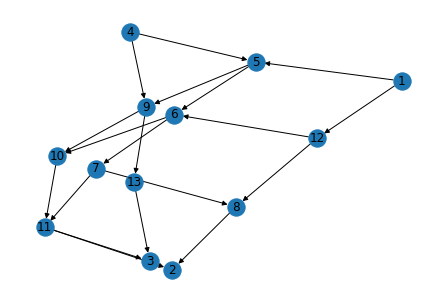

In [285]:
# Create a dictionary that maps each node ID to its (x, y) coordinates
#pos = {node: (data['x'], data['y']) for node, data in network.G.nodes(data=True)}  # or nx.circular_layout(G), nx.random_layout(G)
pos = nx.kamada_kawai_layout(network.G)  # or nx.circular_layout(G), nx.random_layout(G)

# Draw the graph
nx.draw(network.G, pos, with_labels=True)
